In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import re
import wandb

from data import WordSequenceDataset
from model import EncoderOnlyNextTokenPredictor

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\\s]", "", text)  
    return text

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
epochs = 100
learning_rate = 1e-3
window_size = 3
max_vocab_size = 50

In [4]:
dataset = WordSequenceDataset("data/simple_corpus.txt", window_size=window_size, max_vocab_size=max_vocab_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[DEBUG] final samples : 1716


In [5]:
print("# of vocabs", dataset.vocab_size)
print("Top 20 vocabs:", list(dataset.token2idx.keys())[2:22])

# of vocabs 50
Top 20 vocabs: ['not', 'do', 'they', 'you', 'she', 'i', 'he', 'we', 'want', 'to', 'hate', 'love', 'prefer', 'eat', 'need', 'a', 'drink', 'like', 'noodles', 'coffee']


### Dataset & Dataloader

### Model setup

In [6]:
model = EncoderOnlyNextTokenPredictor(vocab_size=dataset.vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Loop

In [7]:
wandb.finish()

In [8]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: imsuviiix (Promise_BERT) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
wandb.init(project="embedding-visualization", config={
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "window_size": window_size,
    "max_vocab_size": max_vocab_size
})

In [10]:
wandb.watch(model.token_embedding, log="all", log_freq=10)

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        grad_norm = torch.norm(model.token_embedding.embedding.weight.grad)
        wandb.log({"embedding_grad_norm": grad_norm.item()})

        embedding_weights = model.token_embedding.embedding.weight.detach().cpu().numpy()
        wandb.log({
            "embedding_weights_step": wandb.Histogram(embedding_weights.flatten())
        })

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")
    wandb.log({"loss": avg_loss, "epoch": epoch})


Epoch 1: Loss = 2.8541
Epoch 2: Loss = 1.8377
Epoch 3: Loss = 1.5974
Epoch 4: Loss = 1.5419
Epoch 5: Loss = 1.5180
Epoch 6: Loss = 1.5134
Epoch 7: Loss = 1.5025
Epoch 8: Loss = 1.4939
Epoch 9: Loss = 1.4876
Epoch 10: Loss = 1.4867
Epoch 11: Loss = 1.4857
Epoch 12: Loss = 1.4867
Epoch 13: Loss = 1.4765
Epoch 14: Loss = 1.4774
Epoch 15: Loss = 1.4773
Epoch 16: Loss = 1.4775
Epoch 17: Loss = 1.4786
Epoch 18: Loss = 1.4725
Epoch 19: Loss = 1.4710
Epoch 20: Loss = 1.4721
Epoch 21: Loss = 1.4664
Epoch 22: Loss = 1.4730
Epoch 23: Loss = 1.4711
Epoch 24: Loss = 1.4644
Epoch 25: Loss = 1.4717
Epoch 26: Loss = 1.4702
Epoch 27: Loss = 1.4684
Epoch 28: Loss = 1.4677
Epoch 29: Loss = 1.4653
Epoch 30: Loss = 1.4645
Epoch 31: Loss = 1.4624
Epoch 32: Loss = 1.4671
Epoch 33: Loss = 1.4644
Epoch 34: Loss = 1.4653
Epoch 35: Loss = 1.4645
Epoch 36: Loss = 1.4613
Epoch 37: Loss = 1.4673
Epoch 38: Loss = 1.4623
Epoch 39: Loss = 1.4659
Epoch 40: Loss = 1.4644
Epoch 41: Loss = 1.4605
Epoch 42: Loss = 1.4625
E

### Non-contextual visualization

In [11]:
def visualize_token_embeddings(model, idx2token):
    emb = model.token_embedding.embedding.weight.detach().cpu().numpy()
    reduced = TSNE(n_components=2, perplexity=5).fit_transform(emb)

    plt.figure(figsize=(8, 6))
    for i, label in idx2token.items():
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=12)
    plt.title("Non-Contextual Token Embedding")
    plt.grid(True)
    plt.show()

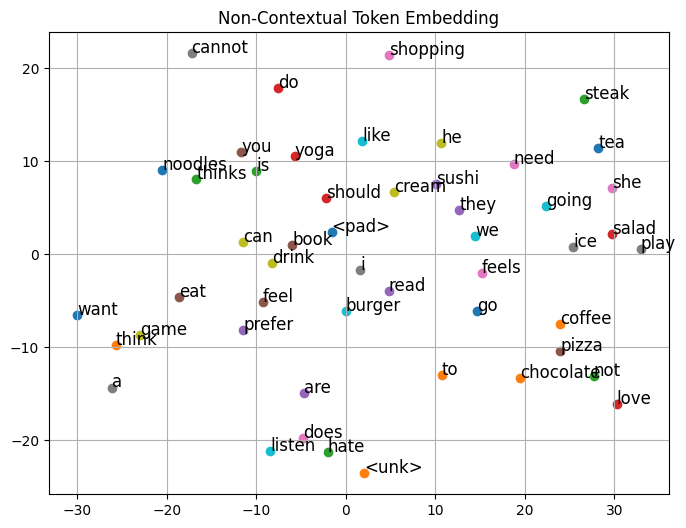

In [12]:
visualize_token_embeddings(model, dataset.idx2token)

### Contextual Embedding

In [34]:
def extract_contextual_embeddings(model, sentence, token2idx):
    model.eval()
    tokens = sentence.split()
    idxs = [token2idx.get(tok, 1) for tok in tokens]  # 1 is <unk>
    x = torch.tensor([idxs]).to(device)

    with torch.no_grad():
        
        tok_emb = model.token_embedding(x)
        pos_emb = model.pos_embedding(x)
        pos_emb = pos_emb.to(tok_emb.device)
        x = tok_emb + pos_emb
        for layer in model.encoder_layers:
            x = layer(x)
        x = model.norm(x)
        return x.squeeze(0).cpu().numpy(), tokens

def visualize_contextual_embeddings(model, token2idx, sentences):
    vectors = []
    labels = []
    for sentence in sentences:
        vecs, toks = extract_contextual_embeddings(model, sentence, token2idx)
        vectors.extend(vecs)
        labels.extend([f"{tok} ({sentence})" for tok in toks])

    reduced = TSNE(n_components=2, perplexity=3).fit_transform(np.array(vectors))

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, label, fontsize=10)
    plt.title("Contextual Embeddings by Sentence")
    plt.grid(True)
    plt.show()


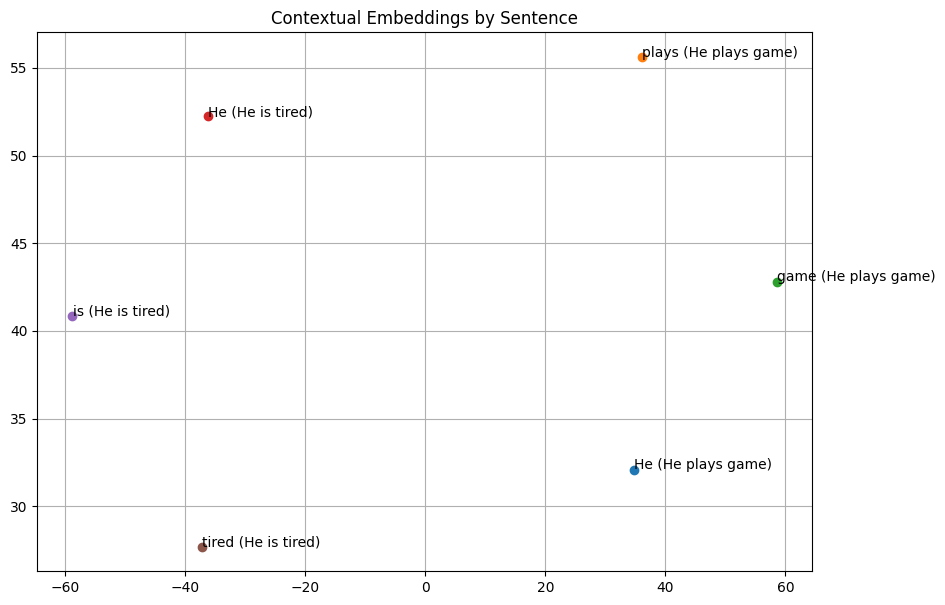

In [35]:
sentences = ["He plays game", "He is tired"]
visualize_contextual_embeddings(model, dataset.token2idx, sentences)